In [2]:
import datetime
import gc
import math
import os
import time

import click
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
import lightgbm as lgb
import pandas as pd

# from reduce_mem import reduce_mem_usage
# from metric import WRMSSEEvaluator

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)

In [3]:
print('read_other_data')
t0 = time.time()
calendar = pd.read_csv('../../new_input/calendar.csv')
sales_train_validation = pd.read_csv('../../new_input/sales_train_evaluation.csv')[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
sell_prices = pd.read_csv('../../new_input/sell_prices.csv')
t1 = time.time()
print('reead_other_data:{0}'.format(t1-t0) + '[sec]')
print('########################')

read_other_data
reead_other_data:10.468345165252686[sec]
########################


In [4]:
df_sub3 = pd.read_csv('../result/rm_ch_apply_cate_be_af_rm_zero/sub_3rd_WRMSSE_0.5839973016241539.csv')
df_sub3.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959',
                 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
df_sub3 = pd.melt(df_sub3, id_vars=['id'], var_name='day', value_name='demand')
df_sub3 = pd.merge(df_sub3, calendar[['d', 'date']], how='left', left_on=['day'], right_on=['d'])
df_sub3

,id,day,demand,d,date
0,HOBBIES_1_001_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
1,HOBBIES_1_002_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
2,HOBBIES_1_003_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
3,HOBBIES_1_004_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
4,HOBBIES_1_005_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
...,...,...,...,...,...
1707435,FOODS_3_823_WI_3_evaluation,d_1969,0.804274,d_1969,2016-06-19
1707436,FOODS_3_824_WI_3_evaluation,d_1969,0.328735,d_1969,2016-06-19
1707437,FOODS_3_825_WI_3_evaluation,d_1969,0.822561,d_1969,2016-06-19
1707438,FOODS_3_826_WI_3_evaluation,d_1969,1.271399,d_1969,2016-06-19


In [5]:
df_sub = pd.read_csv('./sub_049_change_3cv_3_mean.csv')
df_sub.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959',
                 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
df_sub = pd.melt(df_sub, id_vars=['id'], var_name='day', value_name='demand')
df_sub = pd.merge(df_sub, calendar[['d', 'date']], how='left', left_on=['day'], right_on=['d'])
df_sub

,id,day,demand,d,date
0,HOBBIES_1_001_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
1,HOBBIES_1_002_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
2,HOBBIES_1_003_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
3,HOBBIES_1_004_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
4,HOBBIES_1_005_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
...,...,...,...,...,...
1707435,FOODS_3_823_WI_3_evaluation,d_1969,0.671604,d_1969,2016-06-19
1707436,FOODS_3_824_WI_3_evaluation,d_1969,0.343733,d_1969,2016-06-19
1707437,FOODS_3_825_WI_3_evaluation,d_1969,0.823559,d_1969,2016-06-19
1707438,FOODS_3_826_WI_3_evaluation,d_1969,1.411747,d_1969,2016-06-19


In [6]:
df_sub_final = pd.read_csv('./before_1.4x_test.csv')
df_sub_final.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959',
                 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
df_sub_final = pd.melt(df_sub_final, id_vars=['id'], var_name='day', value_name='demand')
df_sub_final = pd.merge(df_sub_final, calendar[['d', 'date']], how='left', left_on=['day'], right_on=['d'])
df_sub_final

,id,day,demand,d,date
0,HOBBIES_1_001_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
1,HOBBIES_1_002_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
2,HOBBIES_1_003_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
3,HOBBIES_1_004_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
4,HOBBIES_1_005_CA_1_validation,d_1942,0.000000,d_1942,2016-05-23
...,...,...,...,...,...
1707435,FOODS_3_823_WI_3_evaluation,d_1969,0.657026,d_1969,2016-06-19
1707436,FOODS_3_824_WI_3_evaluation,d_1969,0.338625,d_1969,2016-06-19
1707437,FOODS_3_825_WI_3_evaluation,d_1969,0.816010,d_1969,2016-06-19
1707438,FOODS_3_826_WI_3_evaluation,d_1969,1.356649,d_1969,2016-06-19


In [7]:
df_sub['demand_nino'] = df_sub3['demand']
df_sub['demand_final'] = df_sub_final['demand']
df_sub = df_sub.merge(sales_train_validation, how='left', on=['id'])

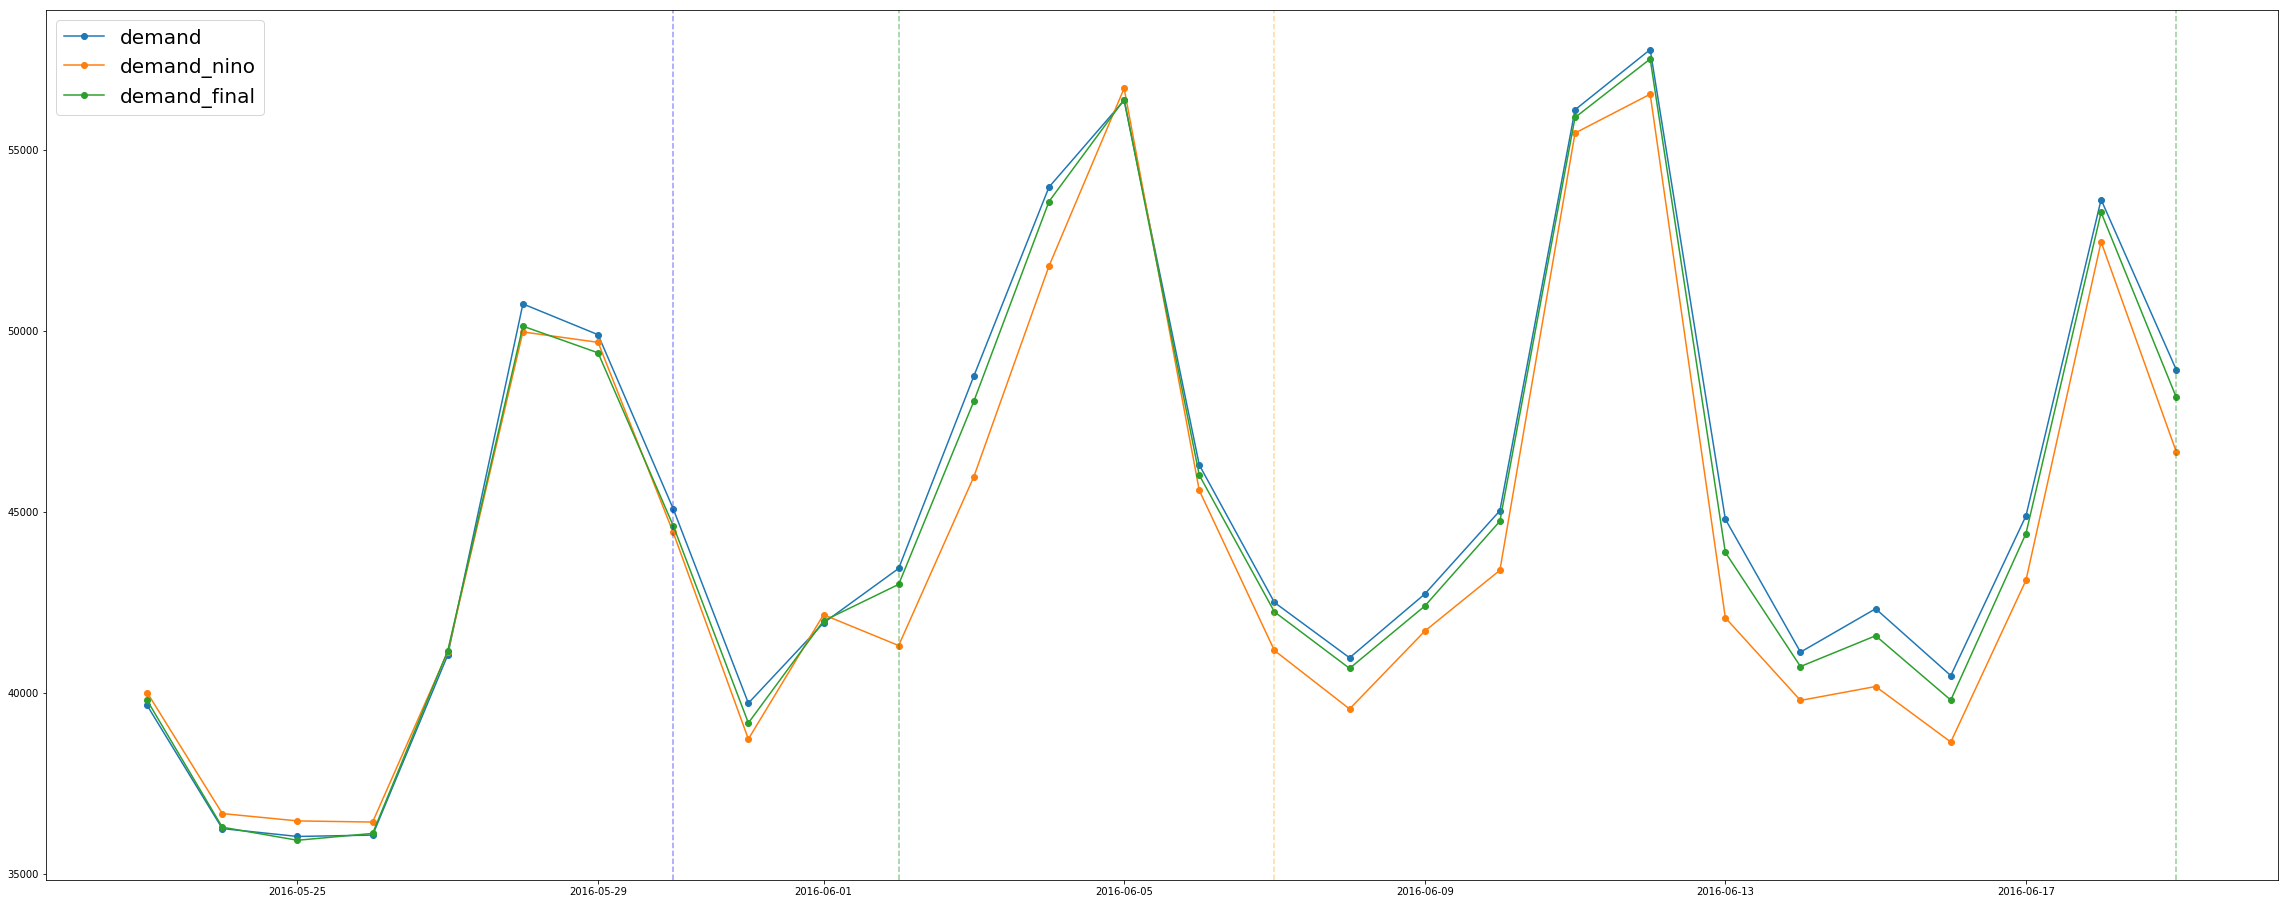

In [8]:
fig = plt.figure(figsize=(40, 16))
ax = fig.add_subplot(1, 1, 1)
df_sub['date']= pd.to_datetime(df_sub['date'])
df_tmp = df_sub.groupby('date')[['demand', 'demand_nino', 'demand_final']].sum().reset_index()
for target in ['demand', 'demand_nino', 'demand_final']:
    ax.plot(df_tmp['date'], df_tmp[target], label=target, marker="o")
    ax.legend(fontsize='20')
ax.axvline(datetime.datetime(2016, 5, 30), color='blue', linestyle='--', alpha=0.4) # Natioonal day
ax.axvline(datetime.datetime(2016, 6, 2), color='green', linestyle='--', alpha=0.4) # NBA
ax.axvline(datetime.datetime(2016, 6, 7), color='orange', linestyle='--', alpha=0.4) # ラマダン
ax.axvline(datetime.datetime(2016, 6, 19), color='green', linestyle='--', alpha=0.4) # NBA
plt.show()

# train期間からの連続的な可視化

In [9]:
df_all = pd.read_pickle('../35093990_33386550_melt_over0sellprice.pkl')
df_all['date'] = pd.to_datetime(df_all['date'])
df_all = df_all.query('date > "2016-02-28"')
df_all = df_all.query('date <= "2016-05-22"')


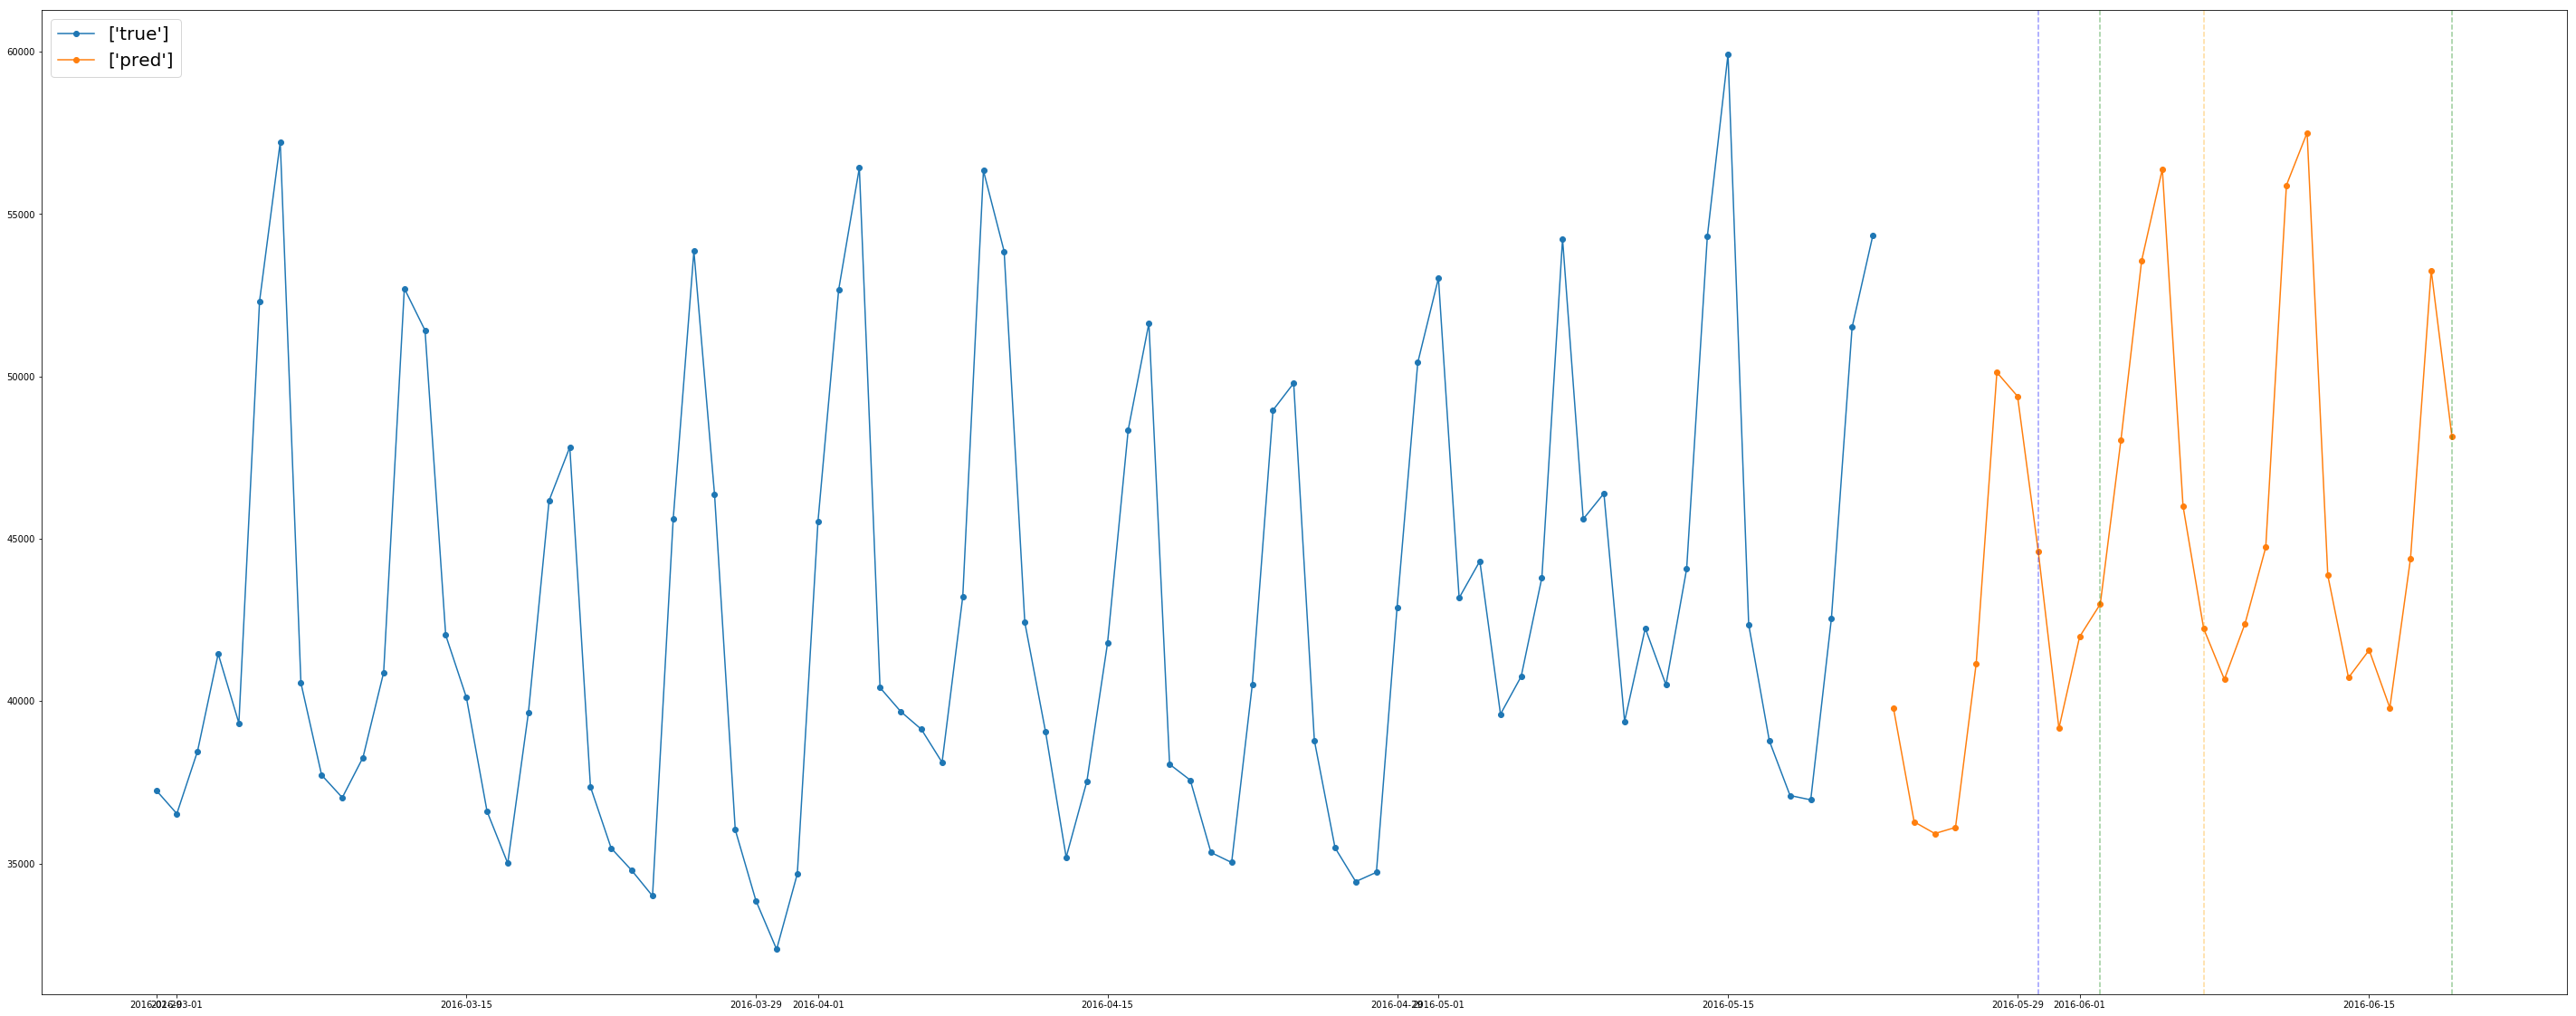

In [14]:
fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(1, 1, 1)
df_tmp = df_all.groupby('date')[['demand']].sum().reset_index()
df_tmp['date'] = pd.to_datetime(df_tmp['date'])
ax.plot(df_tmp['date'], df_tmp['demand'], label=['true'], marker="o")
ax.legend(fontsize='20')

df_tmp = df_sub_final.groupby('date')[['demand']].sum().reset_index()
df_tmp['date'] = pd.to_datetime(df_tmp['date'])
ax.plot(df_tmp['date'], df_tmp['demand'], label=['pred'], marker="o")
ax.legend(fontsize='20')

ax.axvline(datetime.datetime(2016, 5, 30), color='blue', linestyle='--', alpha=0.4) # Memorial day
ax.axvline(datetime.datetime(2016, 6, 2), color='green', linestyle='--', alpha=0.4) # NBA
ax.axvline(datetime.datetime(2016, 6, 7), color='orange', linestyle='--', alpha=0.4) # ラマダン
ax.axvline(datetime.datetime(2016, 6, 19), color='green', linestyle='--', alpha=0.4) # NBA
plt.show()